# Run to prepare environment for the challenge

In [33]:
!pip install duckdb matplotlib seaborn pandas
import duckdb

# Create a connection
conn = duckdb.connect(database=':memory:', read_only=False)

# Create the orders table
conn.execute("""
CREATE TABLE orders (
    order_id INTEGER,
    dealership_id INTEGER,
    status VARCHAR,
    total_cost DOUBLE,
    technician VARCHAR,
    order_date DATE
);
""")

# Create the events table
conn.execute("""
CREATE TABLE events (
    event_id INTEGER,
    order_id INTEGER,
    status VARCHAR,
    cost DOUBLE,
    date_time TIMESTAMP
);
""")

# Create the events table
conn.execute("""
CREATE TABLE technicians (
    technician_id INTEGER,
    name VARCHAR,
    expertise VARCHAR
);
""")

# Create the events table
conn.execute("""
CREATE TABLE dealerships (
    dealership_id INTEGER,
    location VARCHAR,
    manager VARCHAR,
    name VARCHAR
);
""")

# Insert some sample data into the orders table
conn.execute("""
INSERT INTO orders VALUES
(100, 2, 'Completed', 85.00, 'James Brown', '2023-08-01'),
(101, 1, 'Completed', 161.0, 'Jane Smith', '2023-08-10'),
(102, 2, 'In Progress', 175.5, 'James Brown', '2023-08-11'),
(103, 3, 'Completed', 216.0, 'Mary Johnson', '2023-08-10'),
(104, 4, 'Completed', 175.0, 'Robert White', '2023-08-11');
""")

# Insert some sample data into the events table
conn.execute("""
INSERT INTO events VALUES
(1, 100, 'In Progress', 0.00, '2023-08-01 08:00:00'),
(1, 100, 'Completed', 85.00, '2023-08-01 09:00:00'),
(1, 101, 'Received', 40.00, '2023-08-10 08:00:00'),
(2, 101, 'In Progress', 50.25, '2023-08-10 10:00:00'),
(3, 102, 'In Progress', 80.00, '2023-08-10 12:00:00'),
(4, 104, 'Received', 40.00, '2023-08-11 08:00:00'),
(5, 104, 'In Progress', 45.00, '2023-08-11 10:00:00'),
(6, 102, 'Received', 40.00, '2023-08-10 08:30:00'),
(7, 102, 'In Progress', 55.50, '2023-08-10 10:30:00'),
(8, 101, 'Completed', 70.75, '2023-08-10 14:00:00'),
(9, 103, 'Received', 60.00, '2023-08-10 09:00:00'),
(10, 103, 'In Progress', 45.50, '2023-08-10 11:00:00'),
(11, 104, 'Completed', 90.00, '2023-08-11 12:30:00'),
(12, 103, 'Completed', 110.50, '2023-08-10 15:00:00');
""")

# Insert sample data into technicians table
conn.execute("""
INSERT INTO technicians VALUES
(1001, 'Jane Smith', 'Brakes'),
(1002, 'James Brown', 'Transmission'),
(1003, 'Mary Johnson', 'Engine'),
(1004, 'Robert White', 'Tires');
""")

# Insert sample data into dealerships table
conn.execute("""
INSERT INTO dealerships VALUES
(1, 'New York', 'John Doe', 'Doe Dealership'),
(2, 'Los Angeles', 'Jane Lee', 'Jane Dealership'),
(3, 'Chicago', 'Jim Bean', 'Jim Bean Ford'),
(4, 'Houston', 'Jill Ray', 'Houston Toyota');
""")

# Analytics Engineer Challenge: Repair Order Analysis

**Background:**

You are an analytics engineer working for a major automotive service provider. Your task is to analyze the repair order data from various dealerships. You have access to several tables in a DuckDB database as prepared in the cells above:

1. `orders`: Contains repair order details including order ID, dealership ID, status, total cost, and technician ID.
2. `events`: Records event updates for each repair order, including changes to status, cost, and timestamps.
3. `technicians`: Information about technicians including their ID, name, and expertise.
4. `dealerships`: Information about each dealership, including its ID, location, and manager.

Your challenge is to write SQL queries to derive meaningful insights from this data, considering the temporal sequence of events and complex relationships between the tables.

**Tasks:**

1. **CTE for Event Summaries**: Create a CTE that summarizes the events for each order, including the earliest and latest status, total cost, and count of events for each order.

2. **Window Function for Running Costs**: Using a window function, calculate the running total of the cost for each dealership, ordered by `date_time` within the events table.

3. **Joining Tables and Analyzing Data**:
    a. Join the `orders`, `events`, `technicians`, and `dealerships` tables.
    b. Provide insights into the progress and cost trends of each order.
    c. Identify the top-performing technicians and dealerships.

4. **Bonus Task (Optional)**: Create a visualization using the results of your analysis that highlights key trends or findings.

**Schema:**

Here are the tables and their respective columns:

- `orders`: `order_id, dealership_id, status, total_cost, technician_id, order_date`
- `events`: `event_id, order_id, status, cost, date_time`
- `technicians`: `technician_id, name, expertise`
- `dealerships`: `dealership_id, location, manager`

**Hints:**

- You may need to use subqueries, aggregation functions, window functions, and CTEs to accomplish these tasks.
- Consider the chronological sequence of events and handle updates or changes to existing orders.
- Explore correlations between the technicians' expertise, the number of orders handled, and other metrics that may lead to interesting insights.

### Deliverables:

Please provide the SQL queries for each of the tasks, along with a brief explanation of the insights or findings derived from the queries. If you choose to complete the bonus task, include the code and visualization as well.

By completing this challenge, you will demonstrate your ability to handle complex SQL queries, utilize advanced features like CTEs and window functions, and derive meaningful insights from a real-world dataset. Feel free to add more data or complexity if it aligns with the goals of your analysis.

Note: The SQL code for creating tables, inserting sample data, and setting up the database environment are executed in this Google Colab notebook in this step. You may need to adjust the data to match the complexity of the challenge.

## Solution 1: CTE for Event Summaries

In [34]:
# Boilerplate for a potential solution
# Define the CTE and query
event_summary_query = """
WITH EventSummaries AS (
    SELECT
        order_id,
        FIRST_VALUE(status) OVER (PARTITION BY order_id ORDER BY date_time) AS earliest_status,
        LAST_VALUE(status) OVER (PARTITION BY order_id ORDER BY date_time RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS latest_status,
        SUM(cost) AS total_cost,
        COUNT(*) AS event_count
    FROM events
    GROUP BY order_id, status, date_time
)
SELECT * FROM EventSummaries;
"""

# Execute the query
result = conn.execute(event_summary_query)

# Fetch the result as a Pandas DataFrame (useful for further analysis or visualization)
df = result.fetchdf()

order_summaries = df.groupby('order_id').agg(
    earliest_status=pd.NamedAgg(column='earliest_status', aggfunc='first'),
    latest_status=pd.NamedAgg(column='latest_status', aggfunc='last'),
    total_cost=pd.NamedAgg(column='total_cost', aggfunc='sum'),
    event_count=pd.NamedAgg(column='event_count', aggfunc='count')
).reset_index()
print(df)
order_summaries

    order_id earliest_status latest_status  total_cost  event_count
0        104        Received     Completed       40.00            1
1        104        Received     Completed       45.00            1
2        104        Received     Completed       90.00            1
3        101        Received     Completed       40.00            1
4        101        Received     Completed       50.25            1
5        101        Received     Completed       70.75            1
6        103        Received     Completed       60.00            1
7        103        Received     Completed       45.50            1
8        103        Received     Completed      110.50            1
9        102        Received   In Progress       40.00            1
10       102        Received   In Progress       55.50            1
11       102        Received   In Progress       80.00            1
12       100     In Progress     Completed        0.00            1
13       100     In Progress     Completed      

,order_id,earliest_status,latest_status,total_cost,event_count
0,100,In Progress,Completed,85.0,2
1,101,Received,Completed,161.0,3
2,102,Received,In Progress,175.5,3
3,103,Received,Completed,216.0,3
4,104,Received,Completed,175.0,3


## Solution 2: Window Function for Running Costs

In [35]:
event_summary_query = """
SELECT
    e.event_id,
    e.order_id,
    o.dealership_id,
    e.date_time,
    e.cost,
    SUM(e.cost) OVER (PARTITION BY o.dealership_id ORDER BY e.date_time) AS running_total_cost
FROM
    events e
JOIN
    orders o ON e.order_id = o.order_id
ORDER BY
    o.dealership_id, e.date_time;
"""

# Execute the query
result = conn.execute(event_summary_query)

# Fetch the result as a Pandas DataFrame (useful for further analysis or visualization)
df = result.fetchdf()
final_running_totals = df.groupby('dealership_id').last().reset_index()
final_running_totals = final_running_totals[['dealership_id', 'running_total_cost']]
print(df)
final_running_totals

    event_id  order_id  dealership_id           date_time    cost  \
0          1       101              1 2023-08-10 08:00:00   40.00   
1          2       101              1 2023-08-10 10:00:00   50.25   
2          8       101              1 2023-08-10 14:00:00   70.75   
3          1       100              2 2023-08-01 08:00:00    0.00   
4          1       100              2 2023-08-01 09:00:00   85.00   
5          6       102              2 2023-08-10 08:30:00   40.00   
6          7       102              2 2023-08-10 10:30:00   55.50   
7          3       102              2 2023-08-10 12:00:00   80.00   
8          9       103              3 2023-08-10 09:00:00   60.00   
9         10       103              3 2023-08-10 11:00:00   45.50   
10        12       103              3 2023-08-10 15:00:00  110.50   
11         4       104              4 2023-08-11 08:00:00   40.00   
12         5       104              4 2023-08-11 10:00:00   45.00   
13        11       104            

,dealership_id,running_total_cost
0,1,161.0
1,2,260.5
2,3,216.0
3,4,175.0


# Solution 3: Joining Tables and Analyzing Data:

In [36]:
import pandas as pd
event_summary_query = """
SELECT
    o.order_id,
    d.name AS dealership_name,
    t.name AS technician_name,
    o.status AS order_status,
    COUNT(e.event_id) AS number_of_events,
    SUM(e.cost) AS total_order_cost,
    AVG(e.cost) AS average_cost_per_event,
    MAX(e.date_time) AS last_event_date
FROM
    orders o
JOIN
    events e ON o.order_id = e.order_id
JOIN
    technicians t ON o.technician = t.name
JOIN
    dealerships d ON o.dealership_id = d.dealership_id
GROUP BY
    o.order_id, d.name, t.name, o.status
ORDER BY
    total_order_cost DESC, number_of_events DESC;
"""

# Execute the query
result = conn.execute(event_summary_query)
# Fetch the result as a Pandas DataFrame (useful for further analysis or visualization)
df = result.fetchdf()


tech_performance = df.groupby('technician_name').agg(
    total_cost_handled=pd.NamedAgg(column='total_order_cost', aggfunc='sum'),
    number_of_events=pd.NamedAgg(column='number_of_events', aggfunc='sum')
).reset_index()
top_technicians = tech_performance.sort_values(by=['total_cost_handled', 'number_of_events'], ascending=False)
dealership_performance = df.groupby('dealership_name').agg(
    total_revenue=pd.NamedAgg(column='total_order_cost', aggfunc='sum')
).reset_index()
top_dealerships = dealership_performance.sort_values(by='total_revenue', ascending=False)

print(top_technicians.head(), "\n\n",top_dealerships.head())

  technician_name  total_cost_handled  number_of_events
0     James Brown               260.5                 5
2    Mary Johnson               216.0                 3
3    Robert White               175.0                 3
1      Jane Smith               161.0                 3 

    dealership_name  total_revenue
2  Jane Dealership          260.5
3    Jim Bean Ford          216.0
1   Houston Toyota          175.0
0   Doe Dealership          161.0


## Bonus Task

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

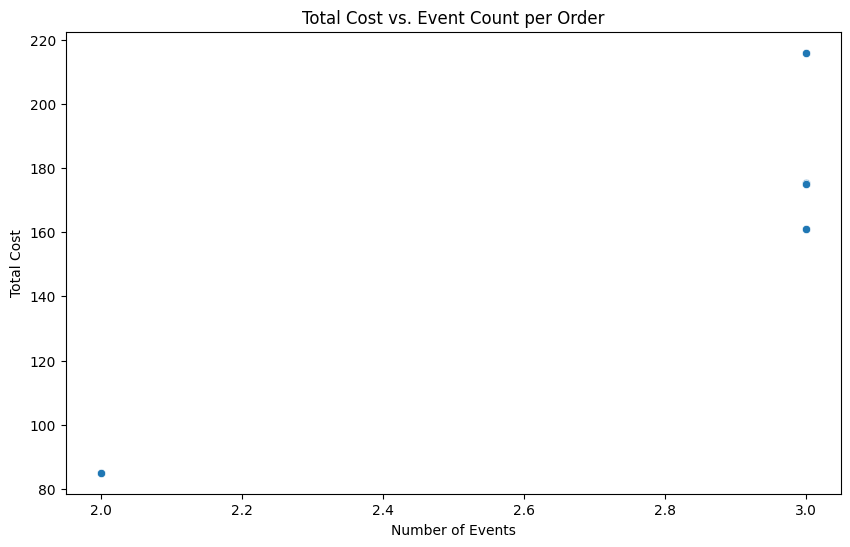

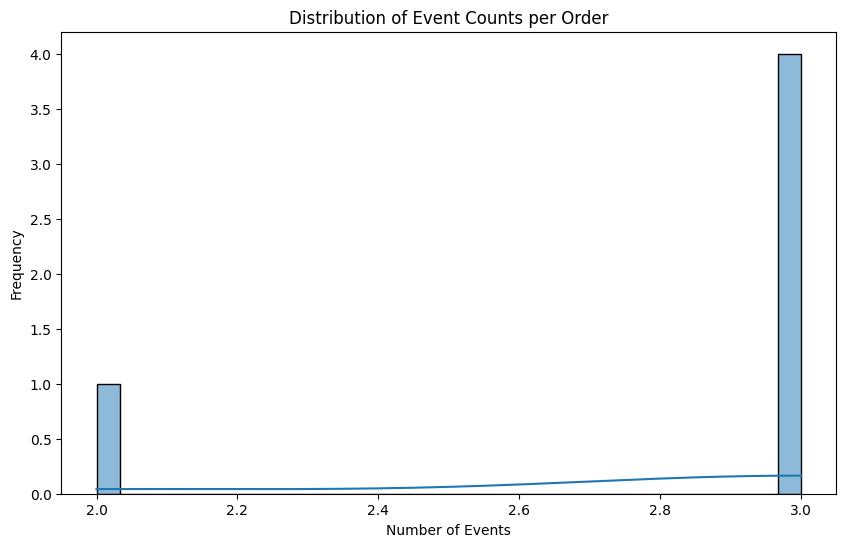

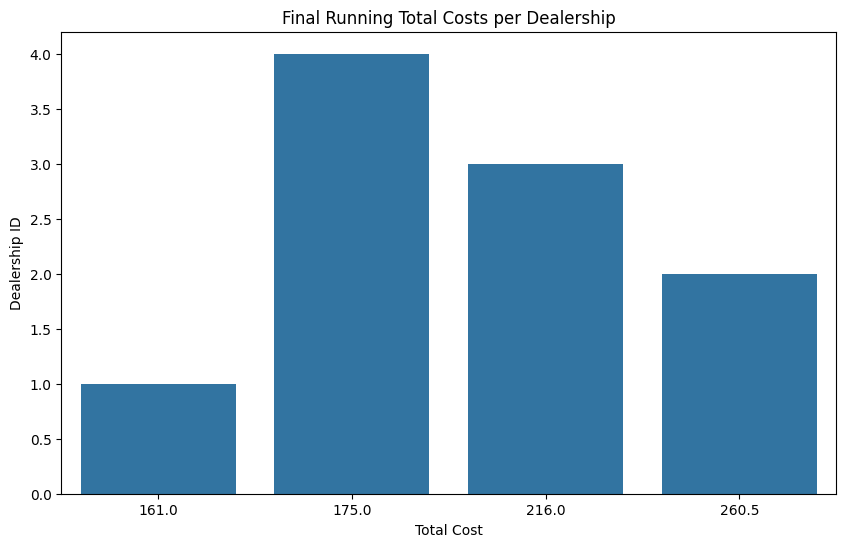

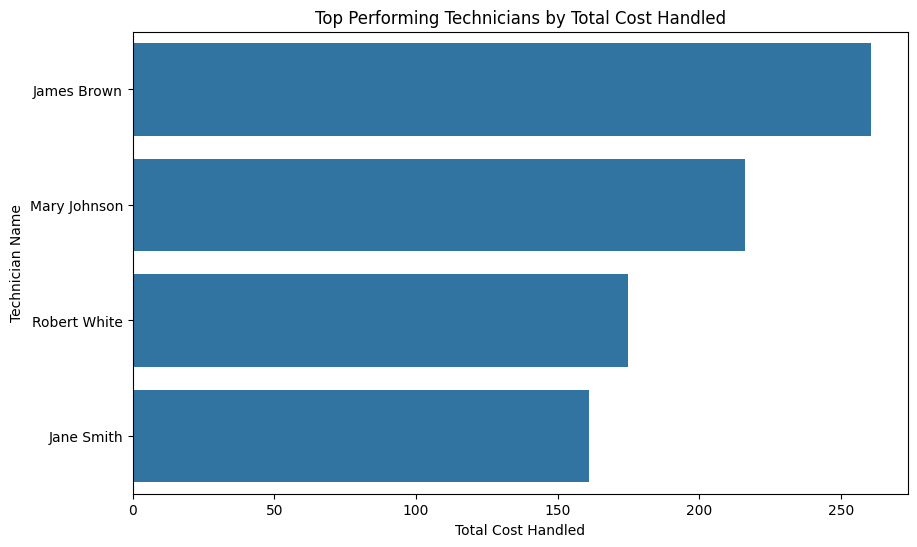

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='event_count', y='total_cost', data=order_summaries)
plt.title('Total Cost vs. Event Count per Order')
plt.xlabel('Number of Events')
plt.ylabel('Total Cost')
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(order_summaries['event_count'], kde=True, bins=30)
plt.title('Distribution of Event Counts per Order')
plt.xlabel('Number of Events')
plt.ylabel('Frequency')
plt.show()


final_running_totals_sorted = final_running_totals.sort_values(by='running_total_cost', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='running_total_cost', y='dealership_id', data=final_running_totals_sorted)
plt.title('Final Running Total Costs per Dealership')
plt.xlabel('Total Cost')
plt.ylabel('Dealership ID')
plt.show()

top_technicians_sorted = top_technicians.sort_values(by='total_cost_handled', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='total_cost_handled', y='technician_name', data=top_technicians_sorted)
plt.title('Top Performing Technicians by Total Cost Handled')
plt.xlabel('Total Cost Handled')
plt.ylabel('Technician Name')
plt.show()

